# Fire Avoidance: Within-Subject 
# n=20


In [26]:
#!/usr/bin/env python3
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import json
import ast
from collections import Counter

sns.set_theme(style="white",font_scale=2.1)

# Config.
CSV_PATH      = "game_trials_export_v1.csv"
SUBJECT_COL   = "prolificId"
PHASE_COL     = "phase"
VEHICLE_COL   = "vehicleType"
PLAN_COL      = "plan_seq"
DANGEROUS_COL = "dangerous_vehicle"
WORRY_COL     = "worry"
SOMA_COL      = "somatic_anxiety"
HITS_COL      = "hits"

# valid-key assignments for Study 2
car_up           = {"e", "c"}
all_truck_up     = {"t", "b"}
small_car_lr     = {"q", "w"}
big_car_lr       = {"z", "x"}
truck_lr         = {"n", "m"}
pickup_truck_lr  = {"y", "u"}


DIRECTION_TO_INDEX = {"left":0,"right":1,"up":2,"down":3}


VALID_KEYS = {
    "small_car":   ["q","w","e","c"],  # L,R,U,D
    "big_car":     ["z","x","e","c"],
    "truck":       ["n","m","t","b"],
    "pickup_truck":["y","u","t","b"],
}


# VALID_KEYS = {
#     "small_car"     : small_car_lr    | car_up,
#     "big_car"       : big_car_lr      | car_up,
#     "truck"         : truck_lr        | all_truck_up,
#     "pickup_truck"  : pickup_truck_lr | all_truck_up,
#     "medium_car"    : car_up,         # shared keys between small & big cars
#     "dump_truck"    : all_truck_up,   # shared keys between dump & pickup trucks
# }

RELEVANT_SET   = {"small_car", "big_car", "truck", "pickup_truck"}
IRRELEVANT_SET = {"medium_car", "dump_truck"}

In [24]:
def parse_plan(seq):
    """Return list of lowercase letters f1om plan_seq (ignore non-letters)."""
    if not isinstance(seq, str):
        return []
    return [ch.lower() for ch in seq if ch.isalpha()]

def parse_json_list(cell):
    if pd.isna(cell):
        return []
    s = str(cell).strip()
    try:
        return json.loads(s)
    except Exception:
        return [p.strip().lower() for p in re.split(r"[,\s]+", s) if p.strip()]
    
def contains_obstacle(x):
    return any(str(v).lower().strip() == "obstacle" for v in parse_json_list(x))

def get_obstacle_moves(row):
    return [move for hit, move in zip(row['hits'], row['routeTaken']) if hit == 'obstacle']

# # Function to map obstacleMoves to keys based on vehicleType
# def map_moves_to_keys(row):
#     print("in the function mapping moves to keys")
#     vehicle = row["vehicleType"]
#     directions = row["obstacleMoves"]
#     keyset = VALID_KEYS.get(vehicle, [])
#     keys = []
#     for direction in directions:
#         idx = DIRECTION_TO_INDEX.get(direction)
#         if idx is not None and idx < len(keyset):
#             keys.append(keyset[idx])
#         else:
#             keys.append(None) 
#     return keys




def map_moves_to_keys(row):
    vtype = str(row["vehicleType"]).lower()
    keys = VALID_KEYS.get(vtype, [])
    out = []
    for d in row.get("obstacleMoves", []) or []:
        i = DIRECTION_TO_INDEX.get(d)
        out.append(keys[i] if i is not None and i < len(keys) else None)
    return out



def parse_and_clean(seq):
    """Parse string to list, then keep only alphabetic lowercase keys."""
    if isinstance(seq, str):
        try:
            parsed = ast.literal_eval(seq)
        except:
            return []
    elif isinstance(seq, list):
        parsed = seq
    else:
        return []

    return parse_plan(parsed) 


In [27]:

df = pd.read_csv(CSV_PATH)
df1 = df[df[PHASE_COL]==1].copy()
df2 = df[df[PHASE_COL]==2].copy()

df1_with_obstacle = df1[df1["hits"].apply(contains_obstacle)].copy()

# Converting to lists
df1_with_obstacle['hits'] = df1_with_obstacle['hits'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df1_with_obstacle['routeTaken'] = df1_with_obstacle['routeTaken'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Aligning obstacle with move
df1_with_obstacle['obstacleMoves'] = df1_with_obstacle.apply(get_obstacle_moves, axis=1)
df1_with_obstacle["obstacleKeys"] = df1_with_obstacle.apply(map_moves_to_keys, axis=1)
print(df1_with_obstacle[['hits', 'routeTaken', 'obstacleMoves', 'obstacleKeys', VEHICLE_COL]])



                                           hits  \
545  [obstacle, reward, reward, reward, reward]   

                               routeTaken obstacleMoves obstacleKeys  \
545  [left, right, right, up, left, left]        [left]          [y]   

      vehicleType  
545  pickup_truck  


In [29]:
subjects_with_obstacle_keys_phase1={d['prolificId']: d['obstacleKeys'] for d in df1_with_obstacle[[SUBJECT_COL,'obstacleKeys']].to_dict("records")}


In [30]:
# The trial where an obstacle was hit in phase 1
print(df1_with_obstacle.shape)
df1_with_obstacle.head()

(1, 38)


,phase,vehicle,startTime,moves,rewardsCollected,obstaclesHit,routeTaken,actions,lastValidKeyTime,hits,...,generalized_correctness_leftright,bias_second_order_valid,bias_second_order_correct,type_generalization,optimalRoute,dangerous_vehicle,worry,somatic_anxiety,obstacleMoves,obstacleKeys
545,1,NaN,NaN,NaN,4,1,"[left, right, right, up, left, left]",NaN,NaN,"[obstacle, reward, reward, reward, reward]",...,NaN,NaN,NaN,NaN,"[""right"",""up"",""left"",""left""]",pickup_truck,21,11,[left],[y]


                                           hits dangerous_vehicle  \
545  [obstacle, reward, reward, reward, reward]      pickup_truck   

      vehicleType  
545  pickup_truck  
Matches: 1/1 (100.0%)


C:\Users\hadas\AppData\Local\Temp\ipykernel_62936\157162358.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="match", data=df1_with_obstacle, palette=["#dd8452", "#4c72b0"])
C:\Users\hadas\AppData\Local\Temp\ipykernel_62936\157162358.py:12: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.countplot(x="match", data=df1_with_obstacle, palette=["#dd8452", "#4c72b0"])


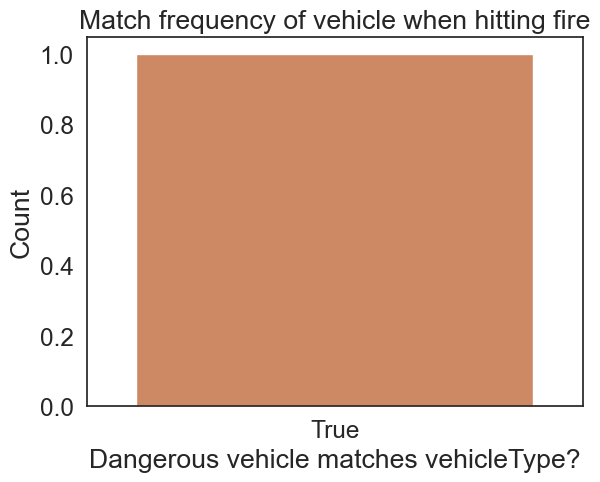

In [31]:
print(df1_with_obstacle[['hits', 'dangerous_vehicle', VEHICLE_COL]])

matches = df1_with_obstacle["dangerous_vehicle"] == df1_with_obstacle[VEHICLE_COL]
match_count = matches.sum()
total_count = len(matches)

print(f"Matches: {match_count}/{total_count} ({match_count/total_count:.1%})")

sns.set_theme(style="white", font_scale=1.6)

df1_with_obstacle["match"] = matches
sns.countplot(x="match", data=df1_with_obstacle, palette=["#dd8452", "#4c72b0"])
plt.xlabel("Dangerous vehicle matches vehicleType?")
plt.ylabel("Count")
plt.title("Match frequency of vehicle when hitting fire")
plt.show()



In [33]:
#df2.groupby([SUBJECT_COL])[PLAN_COL].apply()

In [34]:
# Parsing the plan sequence
df2[PLAN_COL] = df2[PLAN_COL].apply(parse_plan)
print(df2[['phase', PLAN_COL, VEHICLE_COL, SUBJECT_COL]])


      phase      plan_seq vehicleType                prolificId
61        2  [t, q, t, m]  dump_truck  67eda7cef014b05ef5504c28
62        2  [e, n, b, b]  medium_car  67eda7cef014b05ef5504c28
63        2  [e, n, n, b]  dump_truck  67eda7cef014b05ef5504c28
64        2  [t, x, b, b]  dump_truck  67eda7cef014b05ef5504c28
65        2  [n, b, b, q]     big_car  67eda7cef014b05ef5504c28
...     ...           ...         ...                       ...
1780      2  [r, r, w, w]  medium_car  66553eb5f10b5700001d20de
1781      2  [r, r, w, w]  dump_truck  66553eb5f10b5700001d20de
1782      2  [r, r, w, w]  dump_truck  66553eb5f10b5700001d20de
1783      2  [r, r, w, w]       truck  66553eb5f10b5700001d20de
1784      2  [r, r, w, w]  dump_truck  66553eb5f10b5700001d20de

[504 rows x 4 columns]


In [35]:
# The subject id of users who hit an obstacle in phase 1 - and the keys that caused it
subjects_with_obstacle_keys_phase1

{'63af557b3d4f219c3226b7d6': ['y']}

In [36]:
# Keeping only whats not null
df2 = df2[df2[PLAN_COL].apply(lambda l: len(l)>0)]

subject_keys_phase2 = df2.explode([PLAN_COL]).groupby([SUBJECT_COL]).agg({PLAN_COL: list}).to_dict()
subject_keys_phase2 = subject_keys_phase2['plan_seq']
# the frequency of each key pressed by users in phase 2 
subject_key_freq_phase2 = {subject: dict(Counter(k)) for subject, k in subject_keys_phase2.items()}
subject_key_freq_phase2

{'5af5a5c3226ed5000133d67c': {'t': 17,
  'n': 6,
  'c': 13,
  'w': 5,
  'e': 11,
  'q': 4,
  'b': 12,
  'x': 5,
  'm': 9,
  'y': 6,
  'u': 3,
  'z': 5},
 '5c5ca0ce4ee81200018eaf51': {'c': 14,
  'x': 12,
  'w': 12,
  'q': 17,
  'm': 18,
  'e': 10,
  'z': 2,
  'n': 4,
  'y': 7},
 '5cbe04b4f429ff00159de30e': {'e': 5,
  'm': 20,
  'c': 26,
  'q': 21,
  't': 23,
  'n': 1},
 '5ec3a89e1b50db206f73d612': {'c': 16, 'w': 19, 't': 28, 'q': 22, 'b': 11},
 '6159cf5bad649a3ab1abc23f': {'b': 5,
  'q': 20,
  't': 6,
  'y': 1,
  'z': 8,
  'm': 17,
  'u': 3,
  'c': 7,
  'e': 18,
  'r': 1,
  'w': 10},
 '62e154b0682e270b4acdf5ee': {'x': 8,
  'e': 14,
  'z': 8,
  'u': 7,
  't': 14,
  'y': 8,
  'q': 4,
  'c': 14,
  'b': 13,
  'm': 5,
  'n': 1},
 '63af557b3d4f219c3226b7d6': {'y': 11,
  'n': 10,
  'w': 9,
  'b': 24,
  'm': 1,
  't': 26,
  'e': 12,
  'h': 3},
 '641384b3dffcf39ec42d3c23': {'e': 28, 'q': 22, 'c': 27, 'w': 19},
 '657b91830c807b69681bf0ef': {'b': 26, 'm': 18, 'z': 21, 't': 28, 'u': 3},
 '663ea705b

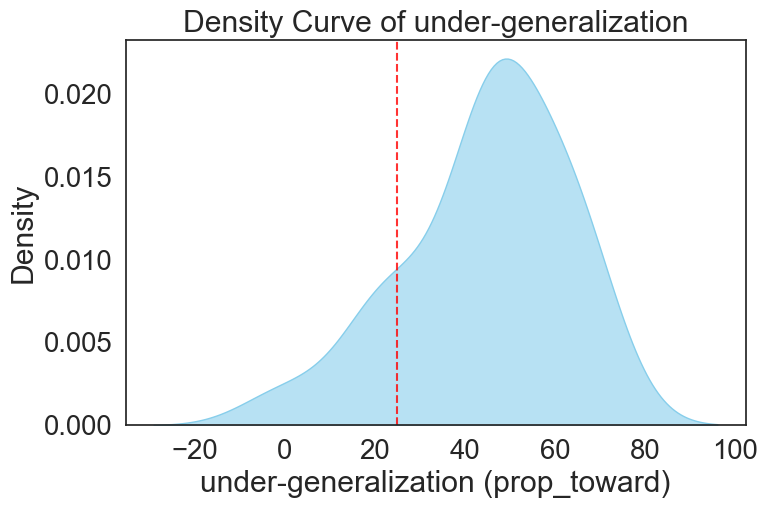

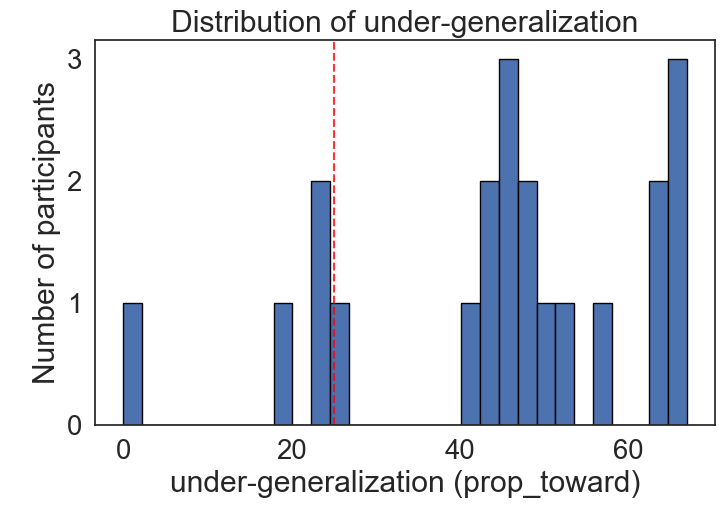

In [37]:
df_summ = pd.read_csv('./participant-summary_v1.csv')
highlight_ids = list(subjects_with_obstacle_keys_phase1.keys())
highlight_vals = df_summ.loc[df_summ["participant"].isin(highlight_ids), "prop_toward"]

sns.set_theme(style="white", font_scale=1.8)

# KDE with vertical lines
plt.figure(figsize=(8,5))
sns.kdeplot(df_summ["prop_toward"].dropna(), fill=True, color="skyblue", alpha=0.6)
for val in highlight_vals:
    plt.axvline(val, color='red', linestyle='--', alpha=0.8)
plt.xlabel("under-generalization (prop_toward)")
plt.ylabel("Density")
plt.title("Density Curve of under-generalization")
plt.show()

# Histogram with vertical lines
plt.figure(figsize=(8,5))
plt.hist(df_summ["prop_toward"].dropna(), bins=30, edgecolor='black')
for val in highlight_vals:
    plt.axvline(val, color='red', linestyle='--', alpha=0.8)
plt.xlabel("under-generalization (prop_toward)")
plt.ylabel("Number of participants")
plt.title("Distribution of under-generalization")
plt.show()

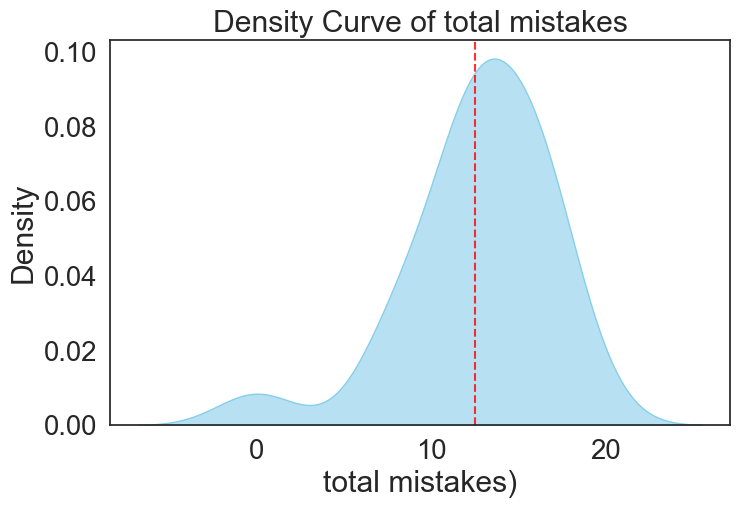

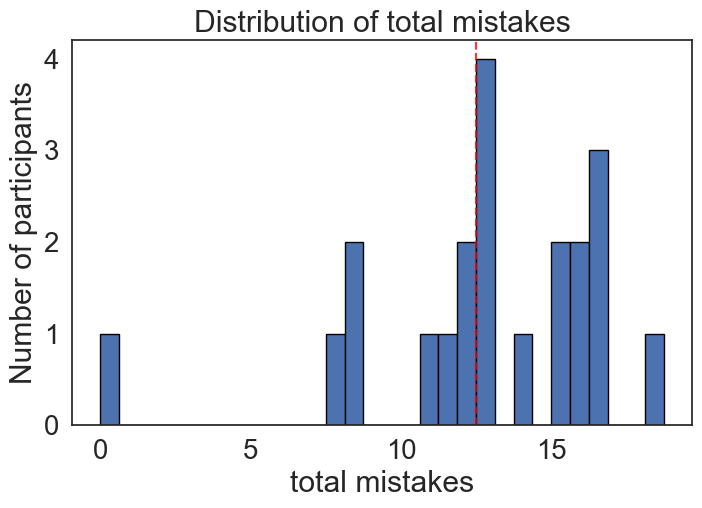

In [39]:
df_summ = pd.read_csv('./participant-summary_v1.csv')

# Add total_mistakes as sum of relevant and dangerous mistakes
df_summ["total_mistakes"] = (df_summ["mistakes_relevant"] + df_summ["mistakes_dangerous"])

highlight_ids = list(subjects_with_obstacle_keys_phase1.keys())
highlight_vals = df_summ.loc[df_summ["participant"].isin(highlight_ids), "total_mistakes"]

sns.set_theme(style="white", font_scale=1.8)

# KDE with vertical lines
plt.figure(figsize=(8,5))
sns.kdeplot(df_summ["total_mistakes"].dropna(), fill=True, color="skyblue", alpha=0.6)
for val in highlight_vals:
    plt.axvline(val, color='red', linestyle='--', alpha=0.8)
plt.xlabel("total mistakes)")
plt.ylabel("Density")
plt.title("Density Curve of total mistakes")
plt.show()

# Histogram with vertical lines
plt.figure(figsize=(8,5))
plt.hist(df_summ["total_mistakes"].dropna(), bins=30, edgecolor='black')
for val in highlight_vals:
    plt.axvline(val, color='red', linestyle='--', alpha=0.8)
plt.xlabel("total mistakes")
plt.ylabel("Number of participants")
plt.title("Distribution of total mistakes")
plt.show()

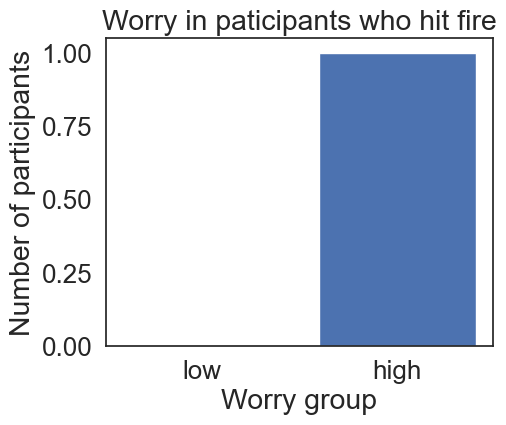

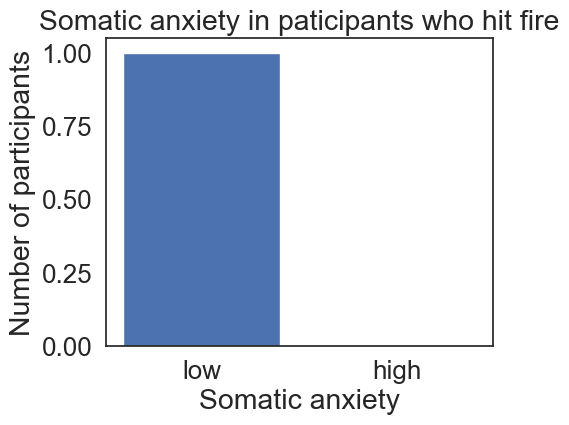

In [17]:
# Filter to just the highlight participants - the ones that hit fire in phase 1
highlight_df = df_summ[df_summ["participant"].isin(highlight_ids)]

worry_counts   = highlight_df["worry_grouped"].value_counts().reindex(["low","high"], fill_value=0)
somatic_counts = highlight_df["somatic_anxiety_grouped"].value_counts().reindex(["low","high"], fill_value=0)


sns.set_theme(style="white", font_scale=1.7)

# worry bar
plt.figure(figsize=(5,4))
plt.bar(worry_counts.index, worry_counts.values)
plt.xlabel("Worry group")
plt.ylabel("Number of participants")
plt.title("Worry in paticipants who hit fire")
plt.show()

# somatic anxiety bar
plt.figure(figsize=(5,4))
plt.bar(somatic_counts.index, somatic_counts.values)
plt.xlabel("Somatic anxiety")
plt.ylabel("Number of participants")
plt.title("Somatic anxiety in paticipants who hit fire")
plt.show()
